In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

import os
from keras.applications.densenet import DenseNet201

import warnings
warnings.simplefilter("ignore")

In [2]:
# Read input images and assign labels based on folder names
print(os.listdir("Artifacts"))

SIZE = 64 #Resize images

['test', 'train']


In [3]:
#Capture training data and labels into respective lists
train_images = []
train_labels = []

for directory_path in glob.glob("Artifacts/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

train\Leukemia
train\Myeloma
train\Normal


In [4]:
train_images.shape

(4520, 64, 64, 3)

In [5]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = []
for directory_path in glob.glob("Artifacts/test/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [6]:
test_images.shape

(1500, 64, 64, 3)

In [7]:
np.unique(train_labels)

array(['train\\Leukemia', 'train\\Myeloma', 'train\\Normal'], dtype='<U14')

In [8]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [9]:
print(np.unique(train_labels_encoded))

[0 1 2]


In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
pip install keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ------ -------------------------------- 20.5/129.1 kB 640.0 kB/s eta 0:00:01
   ------ -------------------------------- 20.5/129.1 kB 640.0 kB/s eta 0:00:01
   ------ -------------------------------- 20.5/129.1 kB 640.0 kB/s eta 0:00:01
   --------------- ----------------------- 51.2/129.1 kB 262.6 kB/s eta 0:00:01
   --------------------- ----------------- 71.7/129.1 kB 357.2 kB/s eta 0:00:01
   --------------------- ----------------- 71.7/129.1 kB 357.2 kB/s eta 0:00:01
   ------------------------------------

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Define your neural network model
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=256, step=32), (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=256, step=32), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv3_units', min_value=32, max_value=256, step=32), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the hyperparameter search space
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Number of trials (model configurations) to test
    executions_per_trial=1,
    directory='cs_tuning',  # Directory to store tuning logs and checkpoints
    project_name='neural_network'  # Name of the project
)

# Perform the hyperparameter search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Trial 3 Complete [00h 06m 30s]
val_accuracy: 0.9566666483879089

Best val_accuracy So Far: 0.9886666536331177
Total elapsed time: 00h 11m 54s
Epoch 1/10
142/142 [==============================] - 18s 123ms/step - loss: 0.5077 - accuracy: 0.7252 - val_loss: 0.3977 - val_accuracy: 0.7813
Epoch 2/10
142/142 [==============================] - 81s 571ms/step - loss: 0.2464 - accuracy: 0.8945 - val_loss: 0.2212 - val_accuracy: 0.9267
Epoch 3/10
142/142 [==============================] - 200s 1s/step - loss: 0.1586 - accuracy: 0.9316 - val_loss: 0.1068 - val_accuracy: 0.9887
Epoch 4/10
142/142 [==============================] - 23s 156ms/step - loss: 0.1475 - accuracy: 0.9414 - val_loss: 0.3202 - val_accuracy: 0.8540
Epoch 5/10
142/142 [==============================] - 15s 108ms/step - loss: 0.1089 - accuracy: 0.9569 - val_loss: 0.1297 - val_accuracy: 0.9640
Epoch 6/10
142/142 [==============================] - 15s 108ms/step - loss: 0.0956 - accuracy: 0.9604 - val_loss: 0.1538 - val_accurac

In [14]:
# Evaluate the model on the test data
loss, accuracy = best_model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


47/47 [==============================] - 1s 23ms/step - loss: 0.1149 - accuracy: 0.9500
Test Loss: 0.11486930400133133
Test Accuracy: 0.949999988079071


47/47 [==============================] - 1s 24ms/step


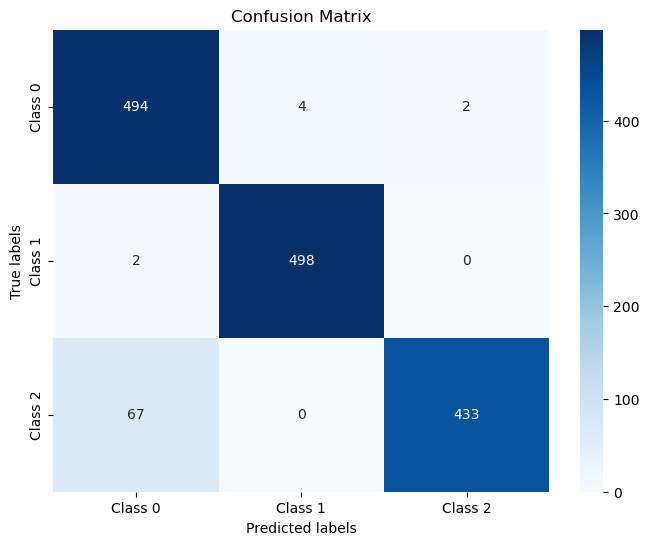

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
y_pred_probs = best_model.predict(x_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])

# Print the classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.99      0.93       500
     Class 1       0.99      1.00      0.99       500
     Class 2       1.00      0.87      0.93       500

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute precision
precision = precision_score(y_test, y_pred, average='weighted')

# Compute recall
recall = recall_score(y_test, y_pred, average='weighted')

# Compute F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.95
Precision: 0.954958814965057
Recall: 0.95
F1 Score: 0.9498867172261239


In [18]:
from sklearn.metrics import jaccard_score

# Compute Jaccard score
jaccard = jaccard_score(y_test, y_pred, average='weighted')

# Evaluate model loss on test data
loss = best_model.evaluate(x_test, y_test)[0]

# Print Jaccard score and error loss
print("Jaccard Score:", jaccard)
print("Error Loss:", loss)


47/47 [==============================] - 1s 24ms/step - loss: 0.1149 - accuracy: 0.9500
Jaccard Score: 0.9062782818568114
Error Loss: 0.11486930400133133


In [19]:
# Make predictions on new data
new_data_predictions = best_model.predict(x_test)


47/47 [==============================] - 1s 23ms/step


In [20]:
# Get predicted class labels
predicted_labels = np.argmax(new_data_predictions, axis=1)


In [21]:
# Define class names (example)
class_names = ["Leukemia", "Myeloma", "Normal"]  # Replace with your actual class names

# Map predicted labels to class names
predicted_class_names = [class_names[label] for label in predicted_labels]

# Print predicted class names
print("Predicted class names:\n", predicted_class_names)


Predicted class names:
 ['Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Myeloma', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Myeloma', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Myeloma', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Myeloma', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukemia', 'Leukem

In [22]:
print(y_test)

[0 0 0 ... 2 2 2]


1/1 [==============================] - 0s 17ms/step
Actual Label: 2
Predicted Label: 2


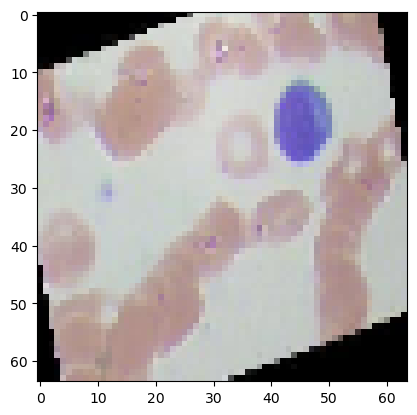

In [23]:
# Select an image from the dataset (example)
image_index = np.random.randint(0, x_test.shape[0]) # Change this to select a different image
selected_image = x_test[image_index]  # Assuming x_test contains the images
plt.imshow(selected_image)
# Use the model to predict the class of the selected image
predicted_probabilities = best_model.predict(np.expand_dims(selected_image, axis=0))
predicted_label = np.argmax(predicted_probabilities)

# Get the actual label of the selected image
actual_label = y_test[image_index]  # Assuming y_test contains the actual labels

# Print the actual label and predicted label
print("Actual Label:", actual_label)
print("Predicted Label:", predicted_label)


In [24]:
best_model.save('model.h5')